# Time Series Analysis

## Overview

Time series analysis deals with ordered sequences of data, e.g., data over time. Consider the following example.

<img src="images/timeseries_general.png" alt="Example for a Time Series" style="width: 600px;"/>

The data we use for the time series analysis are passenger numbers measured every month. Thus, we have an instance for every month in the data. The goal of the time series analysis is to describe the temporal structure of the data, i.e., to find a model that explains how the data changes from month to month. This could be done, e.g., to predict the next value of a time series. A bit more abstract, time series analysis can be described as follows. 

<img src="images/timeseries_abstract.png" alt="Example for a Time Series" style="width: 500px;"/>

Our data are values at enumerated points in time. The time series model describes how the data changes over time. This problem is related to regression: if we were to say that the time is our feature and the value at that time is our dependent variable, we would have a very simple time series analysis.

### The Formal Problem

Formally, we have discrete values $\{x_1, .., x_T\} = \{x_t\}_{t=1}^T$ with $x_t \in \mathbb{R}$. We use the notation $\{x_t\}$ as shorthand for $\{x_t\}_{t=1}^T$. Mathematically, these values can be seen as a series of random variables or as a stochastic process. A core assumption of the time series analysis is that the difference between the time $t$ and the time $t+1$ is equal for all $t=1, ..., T-1$. Thus, we have a fixed step size for the time, e.g., minutes, hours, days, weeks, months, or years. 

A time series consists of different *components*. We consider three such components: 

- The *trend* of the time series $T_t$. The trend is the overall change over time, e.g., a steady growth or decline in values. An example for the trend is, e.g., the constantly growing energy consumption in most countries.  
- The *seasonality* of the time series $S_t$. The seasonality is the result of *seasonal effects*, i.e., regularly recurring effects that lead to an increase or decrease with respect to the general trend. An example for a seasonal effect is, e.g., the change in energy consumption over the year, because it is longer dark outside. 
- The *autocorrelation* between observations $R_t$. The autocorrelation models how the value at time $t$ depends on the prior values, i.e., how $x_t$ is correlated with $x_{t-i}, x_{t-2}, ...$. This autocorrelation models the changes in the time series that are not explained by the trend or seasonality. 

These three components together define the value of our time series, i.e.,

$$x_t = T_t + S_t + R_t.$$

## Box-Jenkins

We consider a special case of time series models, so called *Box-Jenkins* models. With the Box-Jenkins approach, we first need to ensure that the time series is *stationary* and can then model the autocorrelation as a stochastic process that combines the dependencies on past values with a random component. 

Stationary means that the mean value and the variance are constant and do not change over time. For time series, this means that we must first determine the trend and seasonality of the data. The trend is a model for how the mean value of a time series changes over time, the seasonality models how the mean value of a time series changes during seasons. If both are removed, the remaining autocorrelation should be stationary. Because the autocorrelation is modeled for stationary data, Box-Jenkins models achieve this with only few parameters. 

In the following, we consider each aspect of a Box-Jenkins approach for time series analysis in detail. First, we discuss how the trend and seasonality can be determined and removed from the data. Afterwards, we look at ARMA models for the autocorrelation. 

We explain the time series analysis using a running example, i.e., data about air passengers from 1949 to 1961. The data is measured monthly, i.e., the difference between two points is one month. 

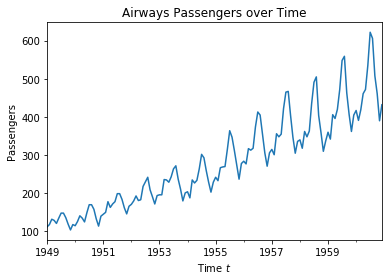

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

air_passengers_df = pd.read_csv("data/AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0, squeeze=True)

plt.figure()
plt.title("Airways Passengers over Time")
air_passengers_df.plot()
plt.xlabel('Time $t$')
plt.ylabel('Passengers')
plt.show()

## Trend and Seasonal Effects

We make the time series stationary by modeling the trend term $T_t$ and the seasonality $S_t$.  The general workflow is always the same:

- We model the trend $T_t$ of the time series $\{x_t\}$.
- We calculate the *detrended* time series $\hat{x}_t = x_t-T_t$.
- We model the seasonality $S_t$ of the detrended time series $\{\hat{x}_t\}$.
- We calculate the *detrended and seasonally adjusted* time series $\hat{\hat{x}}_t\ = \hat{x}_t -S_t$

We consider two different approaches for modeling the trend and seasonality.

### Regression and Seasonal Means

The first approach towards detrending is to use a regression model. The trend of the air passenger data looks linear, i.e., like a steady increase of customers over time. In this case, we can fit a linear regression model to explain the trend.

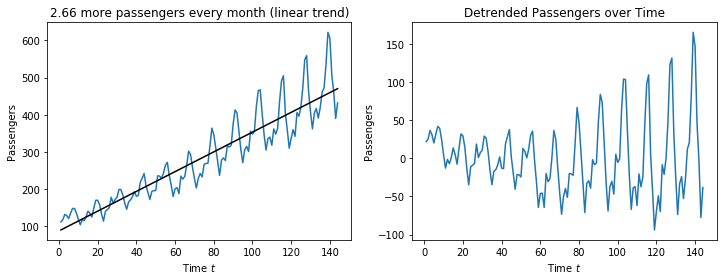

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression


X = np.arange(1,air_passengers_df.shape[0]+1).reshape(-1,1)
Y = air_passengers_df.values

regr = LinearRegression()
regr.fit(X,Y)
T_pred = regr.predict(X)
air_passengers_detrended = air_passengers_df - T_pred

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('%.2f more passengers every month (linear trend)' % regr.coef_[0])
axes[0].plot(X, Y)
axes[0].plot(X, T_pred, color='black')
axes[0].set_xlabel('Time $t$')
axes[0].set_ylabel('Passengers')

axes[1].set_title('Detrended Passengers over Time')
axes[1].plot(X, air_passengers_detrended)
axes[1].set_xlabel('Time $t$')
axes[1].set_ylabel('Passengers')
plt.show()

The plot on the left shows how the linear regression fits the time series. We see that the fit is good and matches the shape of the time series. The slope of the linear regression, i.e., the coefficient is the monthly increase of passengers. Thus, this model for the trend gives us insights into the trend itself: there are 2.66 more passengers every month. 

The plot on the right shows the time series without the trend. We see that there is no increasing trend anymore, the values seem to be centered around zero. This means that the trend was successfully removed. We also observe that the range of the values on the y-axis decreased from $600-100=500$ to $150-(-100)=250$. This means that the trend explains about fifty percent of magnitude the change in the values over time. 

However, we still observe that there is a regular pattern in the fluctuation around zero. This is the seasonality of the data. Recall that the data we use are monthly measurements. Therefore, it is a reasonable conjecture that the seasonality that we observe is a recurring pattern in the same month every year. We can further explore this by adjusting the seasonality through the *seasonal mean*. To calculate the seasonal mean, we must know the length of a season, i.e., after how many time steps the seasonal pattern repeats itself. In case of the sample data, we have a *monthly mean* with a length of $s=12$ timesteps for the seasons. We can then calculate the seasonal pattern as the difference of the overall mean of the detrended time series and the seasonal mean and substract this from the detrended time series, i.e.,

$$\hat{\hat{x}}_t = \hat{x}_t - (mean(\{\hat{x}_{t'}\}_{\{t' \in 1, ..., T: mod(t',s)=mod(t,s)\}}-mean(\{\hat{x}_t\}))$$

where $mod(t,s)$ is the modulo of $t$ divided by $s$. For example, if we have $s=12$ and $t=26$, $mod(t, s)=2$. In that case, the seasonal mean would be calculated over all values $t'$ where $mod(t', s)=2$, i.e., 2, 14, 26, 38, etc.

For our sample data with a seasonality of $s=12$ we get the following.

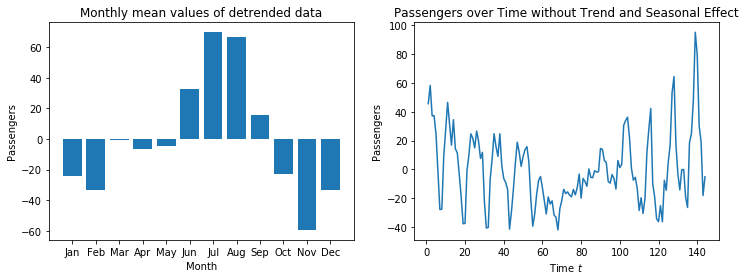

In [26]:
monthly_means = air_passengers_detrended.groupby(air_passengers_detrended.index.month).mean()

# mean of detrended data is zero
air_passengers_detrended_unseasonal = air_passengers_detrended - np.tile(monthly_means,12)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Monthly mean values of detrended data')
axes[0].bar(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], monthly_means)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Passengers')

axes[1].set_title('Passengers over Time without Trend and Seasonal Effect')
axes[1].plot(X, air_passengers_detrended_unseasonal)
axes[1].set_xlabel('Time $t$')
axes[1].set_ylabel('Passengers')
plt.show()

We see that there are over 60 passengers more in July than on average, in November there are about 60 passengers less than average. The seasonal effect of the other months fluctuates between these values. March has almost no seasonal effect. Thus, we again get a great explanatory value for the seasonality, same as for the trend. 

When we use these monthly mean values for seasonal adjustment, we get the time series we see on the right. The range of the y-axis decreased to only $100-(-40)=140$. Thus, the seasonality and the trend explain most of the variation in the data. However, the plot shows that there is still a regular pattern. Please note that every original pattern had a single upwards spike and two downwards spikes next to each other. After seasonal adjustment, we have:

- Two upwards spikes and one downwards spike  before $t=70$.
- Almost no upwards/downwards spikes between $t=70$ and $t=100$. 
- One upwards spike and two downwards spikes after $t=100$.

This shows that the seasonality is not fully corrected. The reason is, that in this data, there is a trend in the seasonal effect: same as the overall number of passengers, the monthly fluctuations also get stronger over the years. In the middle of the data, the seasonal mean matches well with the data, hence no more spikes. At the beginning of the data, the seasonal mean is larger than the actual seasonal effect, which means the seasonal adjustment is too strong and the seasonal pattern is inverted. At the end of the data, the seasonal mean is less than the actual seasonal effect, which means that there is still something of seasonal effect left. 

Overall, our time series is still not fully stationary, as there are still seasonal patterns in the data. However, since the pattern is now relatively weak (decrease in range of the y-axis), it would be possible to use this data to model the autoregressive part of the time series. 

### Differencing

The second approach for modeling the trend and seasonality is based on *differencing*. Differencing is similar to the derivative of a function and more powerful than the adjustment through regression and seasonal means. The idea behind differencing is that the trend is nothing more than the slope of the time series. The slope is nothing more than the first derivative of the time series. If the trend of the time series is not constant, but changes over time, this would be the second order derivative. Thus, if we want to remove the trend, we can use the derivative to do this. 

Differencing us usually implemented with a variant of the *point slope equation* to estimate the slope of a line. The slope between two points $(x_1, y_1), (x_2, y_2)$ is defined as $\frac{y_2-y_1}{x_2-x_1}$. We use that we have equidistant time steps $t$, i.e., to points next to each other in the time series are $(t-1, x_{t-1}), (t, x_t)$ and the slope is

$$\frac{x_t-x_{t-1}}{t-(t-1)} = \frac{x_t-x_{t-1}}{1} = x_t-x_{t-1}.$$

The slope between two points of the time series is the *first-order difference* and we use the notation

$$\Delta^1 x_t = x_t - x_{t-1}.$$

With the first order difference, we detrend time series that have a moving mean value, i.e., $\hat{x}_t = \Delta^1 x_t$. If both the mean value as well as the change of the mean are moving, we can use *second-order differencing*, which is defined as 

$$\Delta^2 x_t = \Delta^1 x_t - \Delta^1 x_{t-1} = x_t - 2\cdot x_{t-1} + x_{t-2}.$$

When we apply first-order differencing to our example, we get the following. 

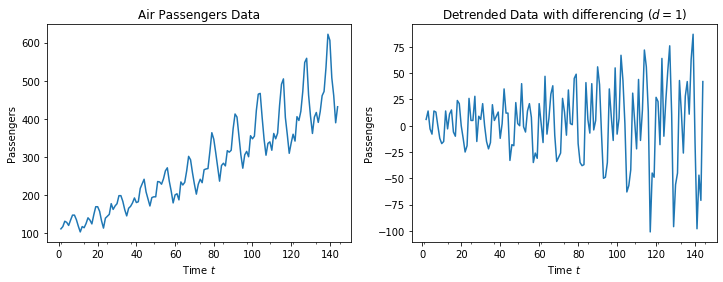

In [27]:
air_passengers_differenced = air_passengers_df.diff(1)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Air Passengers Data' % regr.coef_[0])
axes[0].plot(X, Y)
axes[0].set_xlabel('Time $t$')
axes[0].set_xticks(np.arange(0,13)*12+1, ('1949','','1951','','1953','','1955','','1957','','1959','','1961'))
axes[0].set_ylabel('Passengers')

axes[1].set_title('Detrended Data with differencing ($d=1$)')
axes[1].plot(X, air_passengers_differenced)
axes[1].set_xlabel('Time $t$')
axes[1].set_xticks(np.arange(0,13)*12+1, ('1949','','1951','','1953','','1955','','1957','','1959','','1961'))
axes[1].set_ylabel('Passengers')
plt.show()

The resulting plot looks centered around 0, but there is still a seasonal fluctuation. We observe that the range of the y-axis is only $75-(-100)=175$, i.e., about two thirds of the range of the time series values is explained by the trend. 

Differencing can also be used for seasonal adjustment. In this case, we do not use the difference between two points next to each other, but rather between two consecutive points in time during the season. Thus, if we have a length of a season of $s$, we can calculate our seasonal adjustment as $\hat{\hat{x}} = \Delta_s \hat{x}_t$ with

$$\Delta_s \hat{x}_t = \hat{x}_t - \hat{x}_{t-s}.$$

When we apply seasonal differencing with a length of the season of $s=12$, we get the following. 

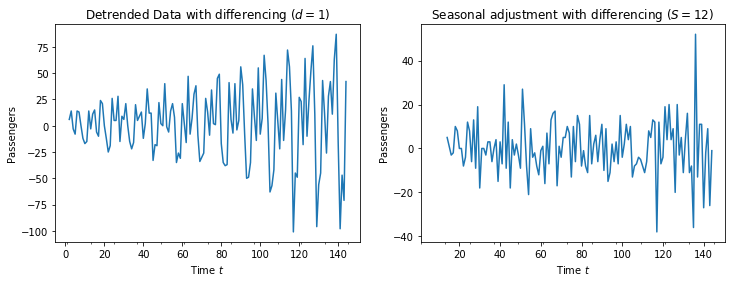

In [28]:
air_passengers_differenced_seasonal = air_passengers_differenced.diff(periods=12)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Detrended Data with differencing ($d=1$)')
axes[0].plot(X, air_passengers_differenced)
axes[0].set_xlabel('Time $t$')
axes[0].set_xticks(np.arange(0,13)*12+1, ('1949','','1951','','1953','','1955','','1957','','1959','','1961'))
axes[0].set_ylabel('Passengers')

axes[1].set_title('Seasonal adjustment with differencing ($S=12$)')
axes[1].plot(X, air_passengers_differenced_seasonal)
axes[1].set_xlabel('Time $t$')
axes[1].set_xticks(np.arange(0,13)*12+1, ('1949','','1951','','1953','','1955','','1957','','1959','','1961'))
axes[1].set_ylabel('Passengers')
plt.show()

There is no pattern left in the plot on the right. The fluctuations around zero look completely random, which is a strong indication that the time series is now stationary. Moreover, the range of the $y-axis$ is further reduced to only $40-(-40)=80$, i.e., about half magnitude of the changes in the time series after detrended are explained through the seasonality. The remainder is the autocorrelation of the time series, that must still be modeled.

### Comparison of the Approaches

The two methods for modeling the trend and seasonality both have advantages and weaknesses. The advantage of regression and seasonal means is that we get interpretable values through the slope of the regression and the monthly mean values. However, this method is limited, because it only works for linear trends and with seasonal effects that have no trend. Thus, the data may not be fully stationary with this approach. 

This is the strength of differencing: it can deal with both changes in the mean, as well as changes in the movement of the mean. This also holds true for the seasonal adjustment, which could also have higher orders, even though we only showed first-order seasonal adjustment. Thus, the likelihood of getting stationary data is higher with this approach. However, we get no interpretable values for the trend or seasonality that quantify the effects. 

## Autocorrelation with ARMA

The last aspect of a time series that we must model is the autocorrelation. 

### Autocorrelation and Partial Autocorrelation

The autocorrelation is the direct relationship of the values of the time series at different points in time. Thus, we have the correlation between the time series with itself. 

> Note:
>
> *Auto* means *self* in Latin, i.e., we have the Latin meaning and not the short form of automatic. If these are mixed up in this case, this does not make sense and can be confusing. 

What the autocorrelation is can be visualized with scatterplots. Below, we visualize the relationship between the time steps of the time series for our running example with both variants of detrending and seasonal adjustment. 

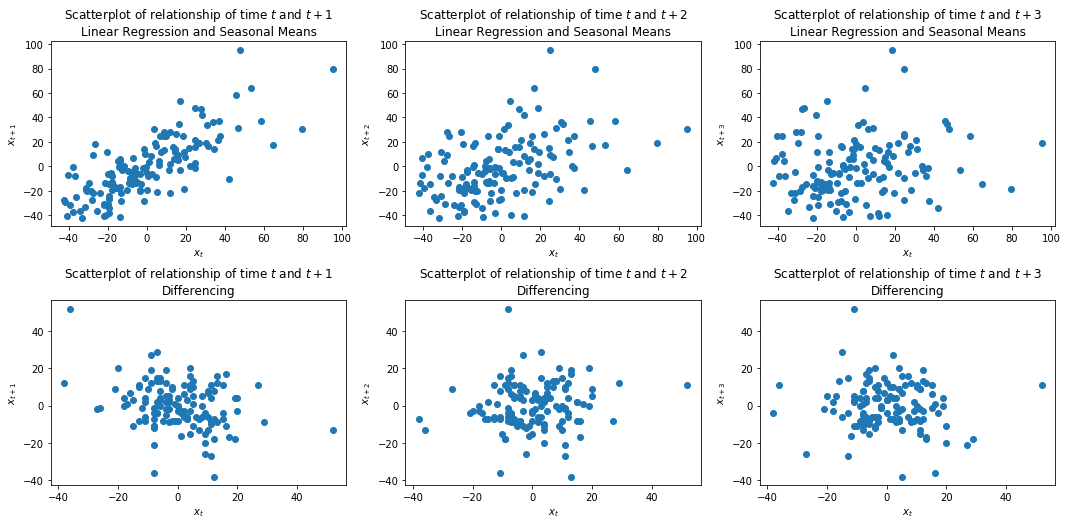

In [29]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(2, 3, figsize=(18, 7))

for i in range(1,4):
    axes[0,i-1].set_title('Scatterplot of relationship of time $t$ and $t+%i$\nLinear Regression and Seasonal Means'%i)
    lag_plot(air_passengers_detrended_unseasonal,lag=i, ax=axes[0,i-1])
    axes[0,i-1].set_xlabel('$x_t$')
    axes[0,i-1].set_ylabel('$x_{t+%i}$'%i)
    
    axes[1,i-1].set_title('Scatterplot of relationship of time $t$ and $t+%i$\nDifferencing'%i)
    lag_plot(air_passengers_differenced_seasonal,lag=i, ax=axes[1,i-1])
    axes[1,i-1].set_xlabel('$x_t$')
    axes[1,i-1].set_ylabel('$x_{t+%i}$'%i)

plt.subplots_adjust(left=None, bottom=0, right=None,
                top=None, wspace=None, hspace=0.4)
plt.show()

The plots in the first column show the relationship with the next time step, the second column two time steps into the future, and the third column three time steps into the future. With the Linear Regression and the seasonal means, we see that there is a linear relationship between $x_t$ and $x_t+1$, which gets weaker with $x_{t+2}$ and vanishes with $x_{t+3}$. This relationship is the autocorrelation of the time series. In the second row, we see that there does not seem to be any autocorrelation within the time series where we used differencing. The relationship between the different time steps looks completely random.

The plots of the autocorrelation above ignore one important aspect: 

- $x_{t+2}$ is correlated with $x_{t+1}$
- $x_{t+1}$ is correlated with $x_{t}$
- How much of the correlation between $x_{t+2}$ and $x_{t}$ is already explained by the indirect correlation between $x_{t+2}$ and $x_{t}$ though $x_{t+1}$? 

The issue is that there is *carry over* between the different points in the time series. While this is hard to parse with the mathematical notation, the meaning of this gets clearer with an example. If the number of passengers in March are correlated with the value in February, and the value in February is correlated with the value in January, then the value of January has an indirect impact on March, because it has an impact on February. Thus, some of the correlation between January and February carries over to March. 

However, there may also be *direct* correlation between January and March. This direct correlation is called *partial autocorrelation*. The partial autocorrelation is the autocorrelation without the carryover, i.e., only the direct correlation.

The plots below show the autocorrelation and the partial autocorrelation of our example. 

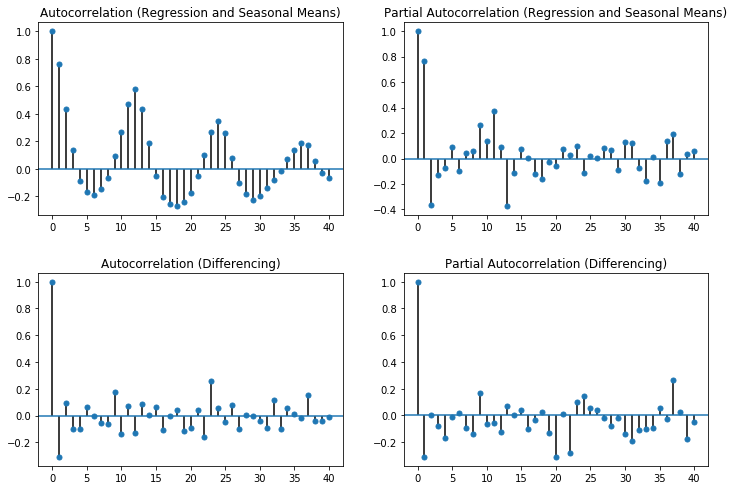

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(12, 7))

plot_acf(air_passengers_detrended_unseasonal, lags=40, alpha=None, ax=axes[0,0], title="Autocorrelation (Regression and Seasonal Means)")
plot_pacf(air_passengers_detrended_unseasonal, lags=40, alpha=None, ax=axes[0,1], title="Partial Autocorrelation (Regression and Seasonal Means)")
plot_acf(air_passengers_differenced_seasonal.dropna(), lags=40, alpha=None, ax=axes[1,0], title="Autocorrelation (Differencing)")
plot_pacf(air_passengers_differenced_seasonal.dropna(), lags=40, alpha=None, ax=axes[1,1], title="Partial Autocorrelation (Differencing)")
plt.subplots_adjust(left=None, bottom=0, right=None,
                top=None, wspace=None, hspace=0.3)
plt.show()

The bars in the plots indicate the strength of the correlation. While there is no fixed guidelines with respect to what is a strong or a weak correlation, commonly used convention is that absolute values below 0.3 indicate that there is no correlation, between 0.3 and 0.5 that there is a weak correlation, between 0.5 and 0.7 that there is a moderate correlation, and above 0.7 that there is a strong correlation. In the following, we are only interested in at least moderate correlations. 

The first row of the plot shows the autocorrelation and partial autocorrelation for the time series that we detrended with the regression and the seasonal means. The autocorrelation shows a clear pattern of alternating positive and negative correlations over time with a periodicity of 12 time steps. This is the residual seasonal effect, that we can observe within the autocorrelations. The partial autocorrelations show that there is a strong direct influence of $x_{t+1}$ and also that the time steps between $t+10$ and $t+13$ have a weak direct influence on $x_t$ that is not explained through the carry over. This is, again, the residual seasonal effect, that we have not corrected.

The second row of the plot shows the autocorrelation and partial autocorrelation for the time series where we used differencing for the adjustments. As we already saw above, there is no correlation between the time steps, both in the autocorrelation and the partial autocorrelation. This observation is the same as we had with the scatterplots. 

### AR, MA and ARMA

What we are still missing is a way to model the autocorrelation. An common approach is to use *AutoRegressive* (AR) or *Moving Average* (MA) models. If both are used together, this is an ARMA model. 

The AR models model a linear relationship between the timesteps. They model the *direct* influence of the past points $p$ in time on the current point in time as

$$c + \epsilon_t + \sum_{i=1}^p a_ix_{t-i}$$

where $c \in \mathbb{R}$ is a constant change over time, $\epsilon_t$ is *white noise*, and $a_i \in \mathbb{R}, i=1, ..., p$ are coefficients that determine the influence past values of the time series. Thus, the AR model combines a fixed change $c$, with a random change $\epsilon_t$ and the last $p$ values of the time series. 

> Note: 
>
> White noise are random variables with an expected value of 0. This means that in the expectation, the white noise does not influence the mean value of time series. Usually, the white noise is modeled by normal distributions with a mean value of 0 and a small standard deviation. 

The MA models are *random*, i.e., they are used to model how random effects influence the values of the time series and are defined as

$$c + \epsilon_t + \sum_{j=1}^q b_j \epsilon_{t-j}$$

$c$ and $\epsilon_t$ are the same as for the AR model. The second part of the MA model ($\sum_{j=1}^q b_j \epsilon_{t-j}$ is the influence of the past noise on the next value. For example, a random increase in air passengers in January may mean that there is a decrease of passengers in February. This would be modeled with a negative coefficient for $b_1$ in the MA model. 

When we combine the AR with the MA, we get the ARMA model for the autocorrelation, which is defined as

$$x_t = c + \epsilon_t + \sum_{i=1}^p a_ix_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j}.$$

In the ARMA model we combine the influence of past values through the coefficients of the AR part of the model, with the influence of random fluctuations.

### Picking $p$ and $q$

What is missing is how the values $p$ and $q$ of an ARMA model are selected, i.e., how many past time steps influence the values of the time series. This is what the plots of the autocorrelation and partial autocorrelation are used for.

For the time series that we detrended with linear regression and seasonal means, we have the following (partial) autocorrelations.

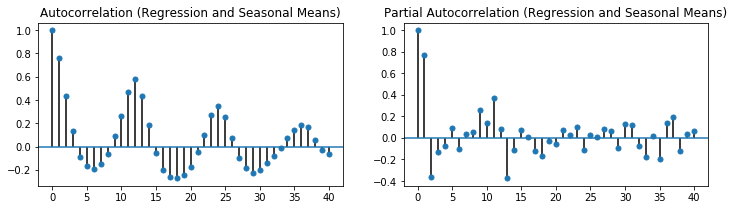

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
plot_acf(air_passengers_detrended_unseasonal, lags=40, alpha=None, ax=axes[0], title="Autocorrelation (Regression and Seasonal Means)")
plot_pacf(air_passengers_detrended_unseasonal, lags=40, alpha=None, ax=axes[1], title="Partial Autocorrelation (Regression and Seasonal Means)")
plt.show()

Since the AR part of the model is the direct influence of past values of the time series, we can use the partial autocorrelation to estimate suitable values. In this case, $p=1$ or $p=13$ would be suitable, as this would capture all values that seem to have a direct impact on the current estimate. With $p=1$ we have a small model, whereas we would get a relatively large model with $p=13$. The large model should be more accurate, because residual seasonal effect is captured, but the model would not be easy to interpret. Moreover, there would be a higher risk of overfitting. 

For the MA part, we are interested in how long we can see the effect of random fluctuations in the model. For time series that can be fully described with an MA term, the value of $q$ can be determined with the autocorrelation, because this tends towards zero after $q$ steps. Thus, we could just look at when the autocorrelation goes towards zero and use this for $q$. This seems to be the case after three full seasons, i.e., at $q=36$. However, this ignores the direct impact of the prior values of the time series of the AR part. For example, the autocorrelation between at $t+1$ is also covered by the partial autocorrelation, most of the autocorrelation at time $t+12$ as well. If we account for this, the impact of the random fluctuations is relatively small. Thus, a suitable $q$ could also be $q=1$ or $q=12$, depending on the choice of $p$.

Together, this means that there are three good candidates for $p$ and $q$:

- $p=1, q=1$ in case a small model is desired and it is acceptable that the residual seasonal effect is not fully accounted for.
- $p=1, q=12$ to use the MA part of the model to account for the residual seasonal effect.
- $p=12, q=1$ to use the AR part of the model to account for the residual seasonal effect.

For the time series after detrending and seasonal adjustment with differencing, this is simpler, because we have the following (partial) autocorrelations.

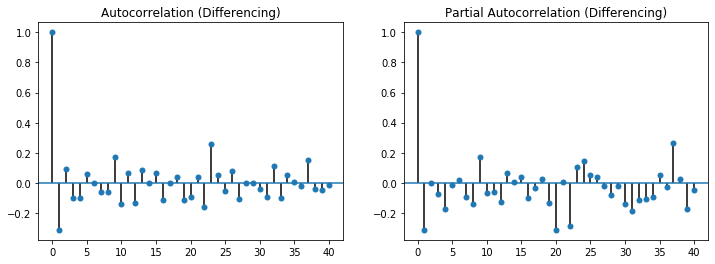

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(air_passengers_differenced_seasonal.dropna(), lags=40, alpha=None, ax=axes[0], title="Autocorrelation (Differencing)")
plot_pacf(air_passengers_differenced_seasonal.dropna(), lags=40, alpha=None, ax=axes[1], title="Partial Autocorrelation (Differencing)")
plt.show()

In this case, we observe no strong partial autocorrelations, i.e., $p=0$ because there is no direct impact of the past values on the current values. In the autocorrelations, we see that the first value is with about -0.3 notable, afterwards this tends to zero. As we explained above, this means that $q=1$ is a suitable choice. 

### ARIMA

Often, you will also find ARIMA models for time series analysis. ARIMA models have the parameter $p, d, q$. ARIMA is the same as ARMA, where $d$-th order differencing is applied to the data. Thus, ARIMA is the same as detrending with differencing and then creating an ARMA model. 